In [1]:
import sys, os, pprint, time
sys.path.append(os.path.abspath('../'))
import argparse, logging, sys
import ptp.reader
import ptp.ls
import ptp.metrics
import ptp.frequency
import ptp.pktselection
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Load data and process 
First load the dataset.

In [2]:
#filename   = "../data/serial-20190821-142641.json" # ocxo without FH traffic
filename   = "../data/serial-20190821-223131.json" # ocxo + FH traffic
#filename   = "../data/serial-20190822-100213.json" # another one with ocxo + FH traffic
reader = ptp.reader.Reader(filename)
reader.run()
print("Dataset info:")
pprint.pprint(reader.metadata)

Dataset info:
{'fh_traffic': {'bitrate': {'dl': 837120000.0, 'ul': 418560000.0},
                'fs': 7680000.0,
                'iq_size': 24,
                'n_rru_active': 1,
                'n_rru_cfg': 1,
                'n_spf': 64,
                'type': 'inline'},
 'hops': 4,
 'oscillator': 'ocxo',
 'start_time': '2019-08-21 22:31:31',
 'sync_period': 0.25}


Next, run frequency offset estimations.

In [3]:
freq_delta = 64

# Raw frequency estimations (differentiation of raw time offset measurements)
freq_estimator = ptp.frequency.Estimator(reader.data, delta=freq_delta)
freq_estimator.set_truth(delta=64)
freq_estimator.optimize()
freq_estimator.process()

print("Observation window for freq. offset estimation: %d" %freq_estimator.delta)

Observation window for freq. offset estimation: 4096


And for comparison, run LS to obtain its frequency offset estimations.

In [4]:
N_ls       = 4096
T_ns       = 1e9/4

# Least-squares estimator
ls = ptp.ls.Ls(N_ls, reader.data, T_ns)
ls.process("eff")

### Initial Analysis

As a sanity check, inspect frequency offset estimations that are going to be used for drift estimations.

In [5]:
# PTP analyser
analyser = ptp.metrics.Analyser(reader.data)

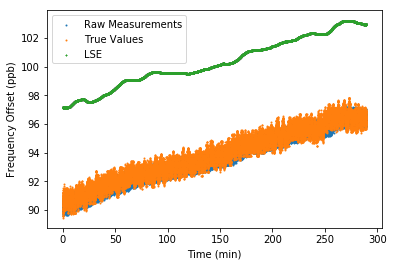

In [6]:
analyser.plot_foffset_vs_time(save=False)

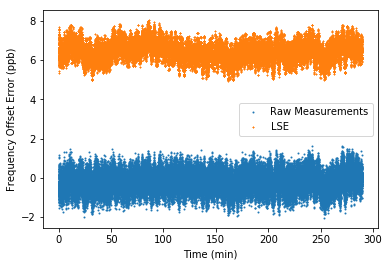

In [7]:
analyser.plot_foffset_err_vs_time(save=False)

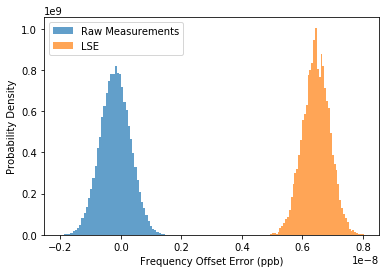

In [8]:
analyser.plot_foffset_err_hist(save=False)

In [9]:
analyser.foffset_err_stats()

[         y_est] Mean: -0.1963 ppb	Sdev:  0.4955 ppb
[      y_ls_eff] Mean:  6.4892 ppb	Sdev:  0.4562 ppb


There are two important comments regarding these plots. The first concerns LS performance. The second concerns the "true frequency measurements".

Note that frequency offset estimations provided by LS tend to be biased. Meanwhile, the variance of the LS estimations is quite similar to the variance of regular frequency offset measurements. Hence, for now we use regular frequency offset measurements when estimating the incremental drifts that are supposed to be used by packet selection.

Regarding "true frequency measurements", note that they are also window-based. Hence, depending on the window size, we will see more or less noise on them. The reason is that the "true time offset measurements" themselves are noisy due to PPS uncertainty. This noise affects frequency offset measurements.

Suppose PPS sync has an uncertainty of 20 ns. If the observation window for true frequency offset values corresponds to 64 PTP exchanges at a rate of 4 exchanges/sec, the observation window is in fact of 16 secs. This way, 20 ns amounts to `20 ns/16 sec` which is slightly more than 1 ppb of noise. The problem, however, is that while we can reduce the measurement noise by increasing the observation window, this comes with the drawback of losing notion of  short-term variations in frequency. 

### Asymmetry

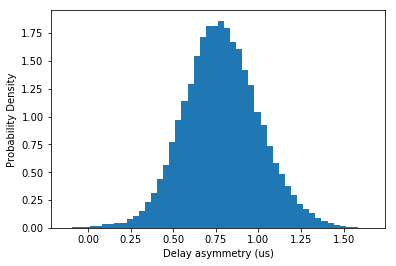

In [10]:
analyser.plot_delay_asym_hist(save=False)

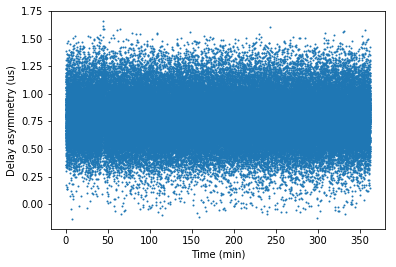

In [11]:
analyser.plot_delay_asym_vs_time(save=False)

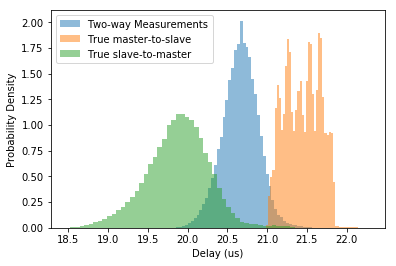

In [12]:
analyser.plot_delay_hist(save=False)

### Drift per exchange

Function `freq_estimator.estimate_drift()` computes the incremental drifts experienced by each PTP exchange based on the frequency offset measurements that were computed by `freq_estimator.process()`.

For comparison, the "true drift" (i.e. `x[n] - x[n-1]`) is computed and plotted next. Note, however, that the true drift suffers from the uncertainty of the PPS synchronization, so it is not highly accurate when observed per iteration (i.e. when comparing the $n$-th iteration to iteration $n-1$).

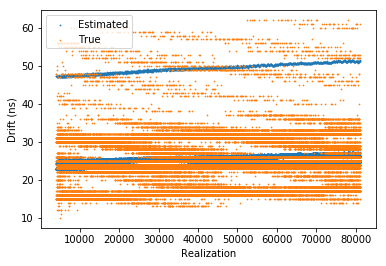

In [13]:
freq_estimator.estimate_drift()

idx        = [r["idx"] for r in reader.data if "drift" in r]
drift_est  = [r["drift"] for r in reader.data if "drift" in r]
drift_true = [(r["x"] - reader.data[i-1]["x"]) for i,r in enumerate(reader.data) if "drift" in r]

plt.figure()
plt.scatter(idx, drift_est, s=0.5, label="Estimated")
plt.scatter(idx, drift_true, s=0.5, label="True")
plt.legend()
plt.ylabel("Drift (ns)")
plt.xlabel("Realization")
plt.show()

### Cumulative drift

Note that because the ground truth has an uncertainty, if we sum the true drift indefinitely, we will accumulate all of the uncertainty over time. This means that if the observation interval used below is large, eventually the two curves will show a significant discrepancy. However, in the short term, their difference should be small, regardless of the index where the observation starts (`i_s`).

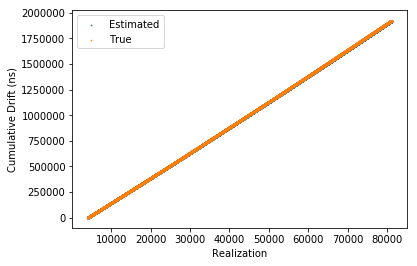

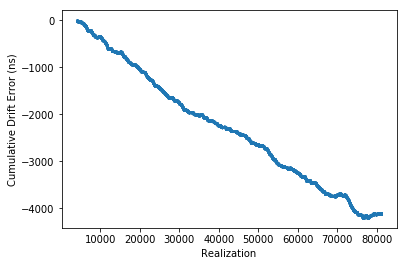

In [14]:
i_s = 0
i_e = len(drift_est)

plt.figure()
plt.scatter(idx[i_s:i_e], np.cumsum(drift_est[i_s:i_e]), s=0.5, label="Estimated")
plt.scatter(idx[i_s:i_e], np.cumsum(drift_true[i_s:i_e]), s=0.5, label="True")
plt.legend()
plt.ylabel("Cumulative Drift (ns)")
plt.xlabel("Realization")
plt.show()

plt.figure()
plt.scatter(idx[i_s:i_e], np.cumsum(drift_est[i_s:i_e]) - np.cumsum(drift_true[i_s:i_e]), s=0.5)
plt.ylabel("Cumulative Drift Error (ns)")
plt.xlabel("Realization")
plt.show()

### Using drift compensation on packet selection

Drift compensation is used to remove the "quasi-deterministic" variation of the time offset prior to applying packet selection operators.

In [15]:
N_movavg   = 128
N_median   = 128
N_min      = 128
N_max      = 128
N_mode     = 128
N_ewma     = 128

In [16]:
def run_all(drift_comp):
    # Sample-average
    pkts = ptp.pktselection.PktSelection(N_movavg, reader.data)
    pkts.process("average", avg_impl="normal", drift_comp=drift_comp)

    # Exponentially weighted moving average
    pkts.set_window_len(N_ewma)
    pkts.process("ewma", drift_comp=drift_comp)

    # Sample-median
    pkts.set_window_len(N_median)
    pkts.process("median", drift_comp=drift_comp)

    # Sample-minimum
    pkts.set_window_len(N_min)
    pkts.process("min", drift_comp=drift_comp)

    # Sample-mode
    pkts.set_window_len(N_mode)
    pkts.process("mode", drift_comp=drift_comp)

    # Sample-maximum
    pkts.set_window_len(N_max)
    pkts.process("max", drift_comp=drift_comp)

### Scenario #1: no drift compensation

In [17]:
# Run all packet selection algorithms without drift compensation
run_all(False)

In [18]:
analyser.toffset_err_stats()

[         x_est] Mean:  779.39 ns	Sdev:  222.07 ns
[x_pkts_average] Mean: -815.87 ns	Sdev:   39.58 ns
[   x_pkts_ewma] Mean: -2410.79 ns	Sdev:   59.84 ns
[ x_pkts_median] Mean: -815.88 ns	Sdev:   55.46 ns
[    x_pkts_min] Mean: -642.20 ns	Sdev:  124.61 ns
[    x_pkts_max] Mean: -986.53 ns	Sdev:  139.73 ns
[   x_pkts_mode] Mean: -809.59 ns	Sdev:  562.41 ns
[      x_ls_eff] Mean:  748.24 ns	Sdev:   45.94 ns


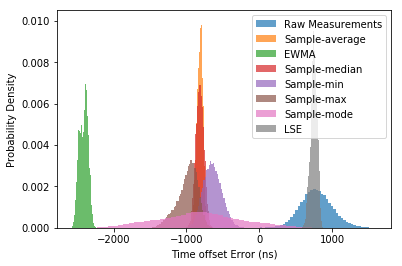

In [19]:
analyser.plot_toffset_err_hist(save=False)

Without drift compensation, we do not expected the average error to be closely around a value corresponding to the asymmetry. This can be seen by comparing the asymmetry values below to the the time offset error histogram above. For example, compare the average time offset error of the sample-average strategy to the average asymmetry. Or, alternatively, compare the average time offset error of the sample-median strategy to the asymmetry of the median $d_{ms}$ and $d_{sm}$.

In [20]:
analyser.delay_asymmetry()

Delay asymmetry analysis:

Metric 	      m-to-s	      s-to-m	   asymmetry
Average	 21446.10 ns	 19879.12 ns	   783.49 ns
Minimum	 20990.00 ns	 18470.00 ns	  1260.00 ns
Maximum	 22296.00 ns	 21349.00 ns	   473.50 ns
Median	 21451.00 ns	 19897.00 ns	   777.00 ns


783.4918015607856

For completeness, we can also inspect max|TE| vs time.

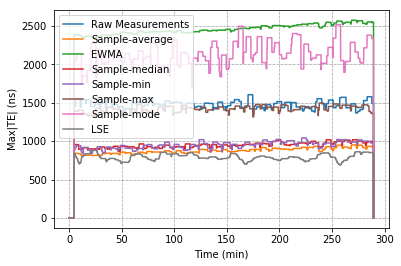

In [21]:
analyser.plot_max_te(save=False, window_len = 1000)

### Scenario #2: enabled drift compensation

In [22]:
# Run all packet selection algorithms with drift compensation
run_all(True)

In [23]:
analyser.toffset_err_stats()

[         x_est] Mean:  779.39 ns	Sdev:  222.07 ns
[x_pkts_average] Mean:  776.06 ns	Sdev:   26.48 ns
[   x_pkts_ewma] Mean:  772.79 ns	Sdev:   20.99 ns
[ x_pkts_median] Mean:  771.22 ns	Sdev:   34.14 ns
[    x_pkts_min] Mean:  1100.01 ns	Sdev:   69.51 ns
[    x_pkts_max] Mean:  396.60 ns	Sdev:  102.30 ns
[   x_pkts_mode] Mean:  787.51 ns	Sdev:  133.38 ns
[      x_ls_eff] Mean:  748.24 ns	Sdev:   45.94 ns


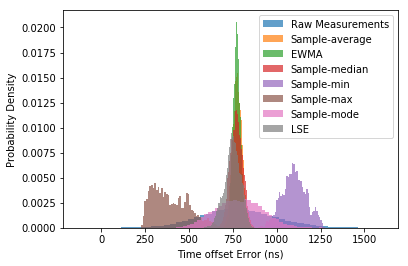

In [24]:
analyser.plot_toffset_err_hist(save=False)

Now, we can see a better match between the average error of the packet-selection estimates with respect to the average asymmetry figures. For instance, the average error of the sample-average above matches with the average delay asymmetry. The average error of the sample-minimum selection operator matches with the asymmetry of the minimum between $d_{ms}$ and $d_{sm}$.

This is the justification for leaving the drift compensation feature enabled by default.

In [25]:
analyser.delay_asymmetry()

Delay asymmetry analysis:

Metric 	      m-to-s	      s-to-m	   asymmetry
Average	 21446.10 ns	 19879.12 ns	   783.49 ns
Minimum	 20990.00 ns	 18470.00 ns	  1260.00 ns
Maximum	 22296.00 ns	 21349.00 ns	   473.50 ns
Median	 21451.00 ns	 19897.00 ns	   777.00 ns


783.4918015607856

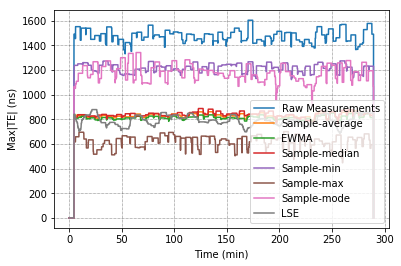

In [26]:
analyser.plot_max_te(save=False, window_len = 1000)

The above highlights also that all packet selection methods are outperforming the raw measurements when drift compensation is enabled. This is what we would expect.